In [1]:
using Plots, SparseArrays, LinearAlgebra, IterativeSolvers

include("geometricMultiGrid.jl")
include("constructions1D.jl")
include("constructions2D.jl")

pointsource_half2D (generic function with 1 method)

In [2]:
struct myPreconditioner
    precon::Function
end

function LinearAlgebra.ldiv!(y, P::myPreconditioner, x)
    y .= P.precon(x)
    return y
end

function LinearAlgebra.ldiv!(P::myPreconditioner, x)
    x .= P.precon(x)
    return x
end

# Define \ for VcyclePreconditioner
function LinearAlgebra.:\(P::myPreconditioner, x)
    return P.pre_con(x)
end

function preconditioner(n, sigma,f)
    helmholtz2D_sigma(x) = helmholtz2D(x, sigma)
    wjacobi_omega(A, f, u) = wjacobi(A, f, u, 2 / 3)
    pres(x) = real(geoVcycle(
                mat = helmholtz2D_sigma,
                f = x,
                u = zero(x),
                nu1 = 1,
                nu2 = 1,
                relax = wjacobi_omega,
                restrict = simple_restrict2D,
                interpolate = simple_interpolate2D,
                recursion_depth = 100,
                dimensions = 2
            ))

    return myPreconditioner(pres)
end

preconditioner (generic function with 1 method)

In [8]:
n = 128
f = float(pointsource_half2D(n)) 
solutions = []
histories = []
preconditioner_values = [-600-100im,-600-300im,-600-600im,  -600-2000im, -600-10^4 *im]

sol, history = gmres(helmholtz2D(n, -600), f , log=true,maxiter = 350,restart=500)
push!(solutions, sol)
push!(histories, history)
for value in preconditioner_values
    sol, history = gmres(helmholtz2D(n, -600), f, Pl=preconditioner(n, value,f), log=true,maxiter = 400 ,restart=500)
    push!(solutions, sol)
    push!(histories, history)
end

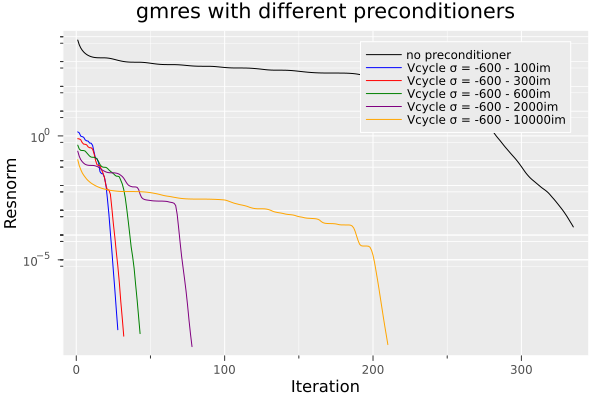

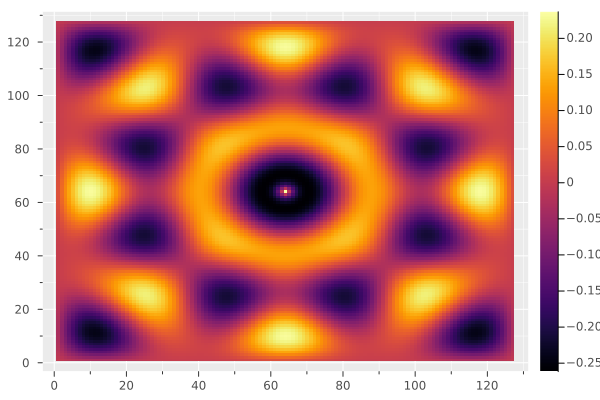

In [10]:
n = 128
colors = [:black, :blue, :red, :green, :purple, :orange]
labels = ["no preconditioner"]
append!(labels, ["Vcycle σ = $σ" for σ in preconditioner_values])
p = plot(
    yscale=:log10,
    legend=true,
    linewidth=2,
    grid=true,
    xlabel="Iteration",
    ylabel="Resnorm",
    title="gmres with different preconditioners")

for i in 1:length(histories)
    plot!(p, histories[i].data[:resnorm], linecolor=colors[i], label=labels[i])
end
display(p)
# savefig(p, "../code/plts/gmres_pointsource.pdf")

heatmap(reshape(solutions[1], n - 1, n - 1))

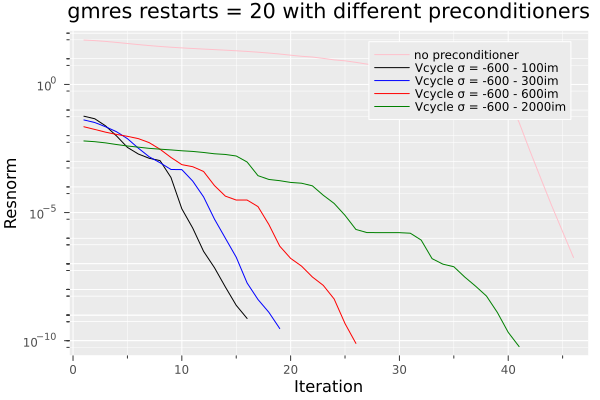

In [7]:
n = 64
restarts = 100
f = wave_basis_2D(n,6,6) + wave_basis_2Dx(n,8) 
preconditioner_values = [-600-100im,-600-300im,-600-600im,  -600-2000im ]
theme(:ggplot2)
p = plot(
    yscale=:log10,
    legend=true,
    linewidth=2,
    xlabel="Iteration",
    ylabel="Resnorm",
    title="gmres restarts = 20 with different preconditioners")
sol, history = gmres(helmholtz2D(n, -600), f , log=true,maxiter = 500,restart=restarts)
plot!(p,history.data[:resnorm], label="no preconditioner",color =:pink )

for (i,value) in enumerate(preconditioner_values)
    sol, history = gmres(helmholtz2D(n, -600), f, Pl=preconditioner(n, value,f), log=true,maxiter = 500,restart=restarts)
    plot!(p,history.data[:resnorm], label="Vcycle σ = $value",color =colors[i] )
end

display(p)
# savefig(p, "../code/plts/gmres_combined_wave_restarts.pdf")